In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
import stanza
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [3]:
chv = pd.read_csv('db/chat_view.csv')
msg = pd.read_csv('db/message.csv')

In [4]:
msg = msg.loc[:, ['chat_row_id', 'timestamp', 'received_timestamp', 'text_data', 'from_me']]
msg = msg.tail(-1)

In [5]:
def mapping(id):
    phone = chv.loc[chv['_id'] == id, 'raw_string'].iloc[0]
    phone = phone.split('@')[0]
    return phone

msg['number'] = msg['chat_row_id'].apply(lambda x: mapping(x))
msg = msg[msg['text_data'].notna()]
msg.head()

,chat_row_id,timestamp,received_timestamp,text_data,from_me,number
11,6,1.625666e+12,1.625666e+12,😀¡Hola! estamos felices de tenerte por aquí.\n...,1,573004751834
12,6,1.625666e+12,1.625666e+12,Hola cami,0,573004751834
13,6,1.625667e+12,1.625667e+12,Acuerdate siempre despues del saludo terminar ...,0,573004751834
14,6,1.625667e+12,1.625667e+12,Y los contactos de cierre,0,573004751834
15,6,1.625667e+12,1.625667e+12,Este estuvo perfecto solo falto los contactos,0,573004751834


In [6]:
msg['timestamp'] = [datetime.fromtimestamp(x/1000) for x in msg['timestamp']]
msg['received_timestamp'] = [datetime.fromtimestamp(x/1000) for x in msg['received_timestamp']]
msg.tail()

,chat_row_id,timestamp,received_timestamp,text_data,from_me,number
99650,7994,2023-03-09 11:55:48.698,1969-12-31 19:00:00.000,La vivienda fue intervenida anteriormente,1,120363048209791822
99651,7994,2023-03-09 11:55:58.021,1969-12-31 19:00:00.000,Por humedades,1,120363048209791822
99652,7994,2023-03-09 11:56:29.000,2023-03-09 11:56:31.067,Cuando haya goteras revisemos antes que no hay...,0,120363048209791822
99662,1,2023-03-09 12:02:38.000,2023-03-09 12:02:45.740,TBT,0,status
99664,1,2023-03-09 12:02:39.000,2023-03-09 12:02:45.772,TBT,0,status


In [7]:
msg.to_csv('db/chat_message.csv')

In [20]:
chmss = pd.read_csv('db/chat_message.csv')

In [21]:
client = chmss.query('from_me == 0')
client.drop(['from_me', 'chat_row_id'], axis=1, inplace=True)
client.to_csv('db/client_chats.csv')

/tmp/ipykernel_95077/4290368740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client.drop(['from_me', 'chat_row_id'], axis=1, inplace=True)


In [11]:
client_text = client['text_data'].to_list()
client_text_question = client_text
client_text = ' '.join(client_text)
client_text = client_text.lower()
client_text = re.sub(r'#(\w+)', '', client_text, re.UNICODE)
client_text = client_text.split()
client_text = [x if len(x) <= 20 and len(x) > 3 else '' for x in client_text]

In [22]:
client['timestamp'] = client['timestamp'].astype('datetime64[ns]')
client['Year'] = client['timestamp'].dt.year
client['Month'] = client['timestamp'].dt.month
client['Day'] = client['timestamp'].dt.day
client['Hour'] = client['timestamp'].dt.hour
client.drop(['timestamp', 'received_timestamp'], axis=1, inplace=True)

/tmp/ipykernel_95077/640924656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client['timestamp'] = client['timestamp'].astype('datetime64[ns]')
/tmp/ipykernel_95077/640924656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client['Year'] = client['timestamp'].dt.year
/tmp/ipykernel_95077/640924656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [23]:
first_mssg = client.groupby(by='number').head(1).sort_values(('number'))
first_mssg.head()

,Unnamed: 0,text_data,number,Year,Month,Day,Hour
39664,49796,pdf_20220528_091937_0000.pdf,120363024667687096,2022,5,28,10
73154,94260,https://m.facebook.com/construvidsas/ síganos ...,120363030315000268,2023,1,10,8
75724,97352,Calendarios Postventa Sem 06 - 10.pdf,120363048209791822,2023,2,4,11
24547,29870,Enlace:\nhttps://fb.me/11hPh7qhf\n\n¿Qué servi...,13056842789,2021,11,28,9
75907,97560,Hola! Necesito asesoría sobre estudio de crédi...,13123831371,2023,2,10,17


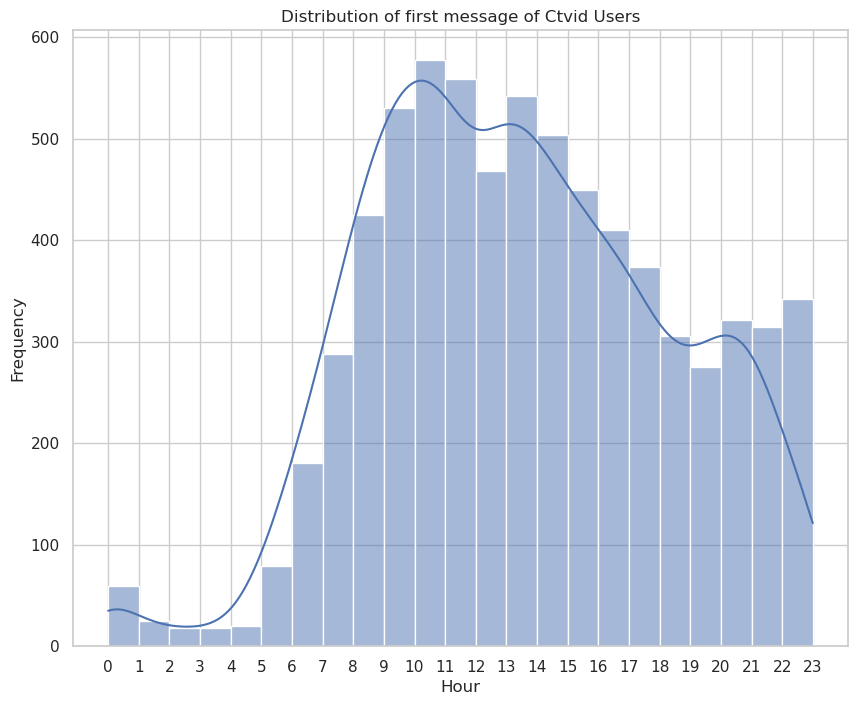

In [24]:
sns.histplot(data=first_mssg, x="Hour", binwidth=1, kde=True)
plt.xlabel('Hour')
plt.xticks(range(0, 24))
plt.ylabel('Frequency')
plt.title('Distribution of first message of Ctvid Users')
plt.show()

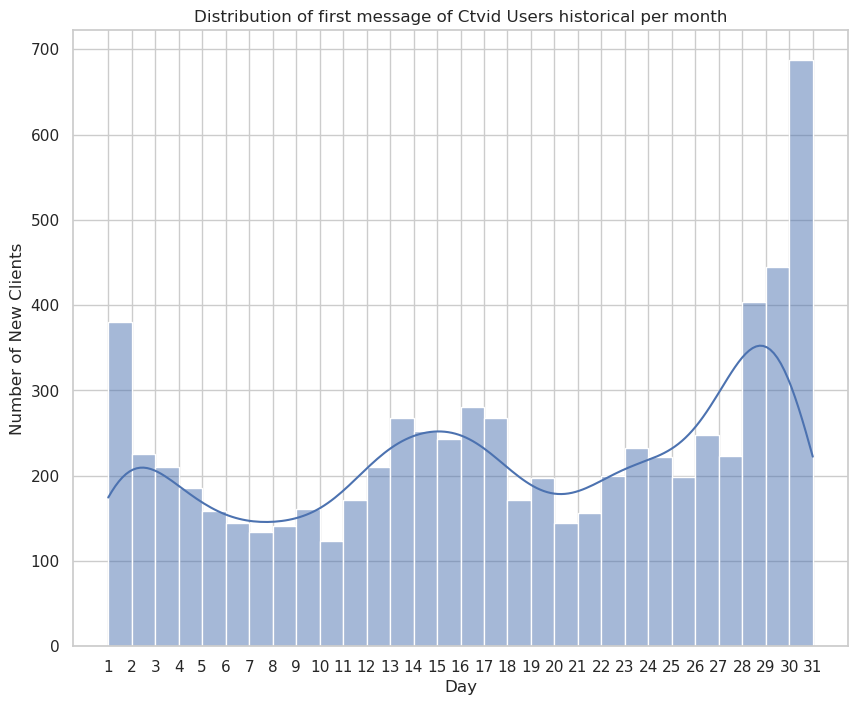

In [25]:
sns.histplot(data=first_mssg, x="Day", binwidth=1, kde=True, )
plt.xlabel('Day')
sns.set(rc={"figure.figsize":(10, 8)})
plt.xticks(range(1, 32))
plt.ylabel('Number of New Clients')
plt.title('Distribution of first message of Ctvid Users historical per month')
plt.show()

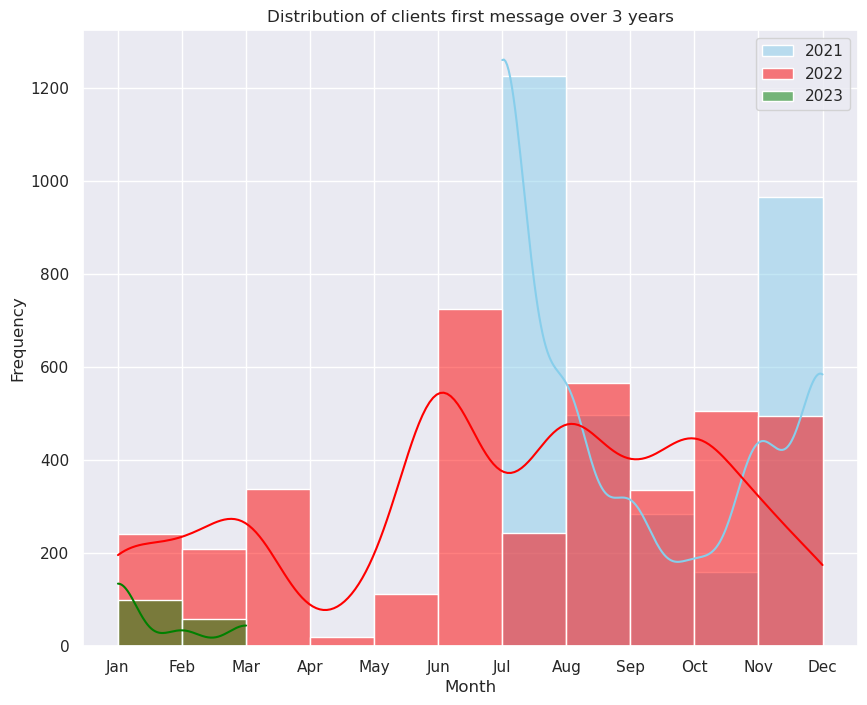

In [26]:
import calendar
month_names = [calendar.month_name[i][:3] for i in range(1, 13)]

first_year = first_mssg.loc[first_mssg['Year'] == 2021]
second_year = first_mssg.loc[first_mssg['Year'] == 2022]
third_year = first_mssg.loc[first_mssg['Year'] == 2023]

sns.histplot(data=first_year, x="Month", label='2021',color='skyblue', binwidth=1, kde=True)
sns.histplot(data=second_year, x="Month", label='2022',color='red', binwidth=1, kde=True)
sns.histplot(data=third_year, x="Month", label='2023',color='green', binwidth=1, kde=True)

plt.xlabel('Month')
plt.xticks(range(1, 13), month_names)
plt.ylabel('Frequency')
plt.title('Distribution of clients first message over 3 years')
plt.legend()
sns.set_style('whitegrid')



plt.show()

In [28]:
# Guardar la base de datos procesada
client.to_csv('db/whatsapp_proc.csv')

In [60]:
# Preguntas
stanza.download('es', verbose=False)
es_nlp = stanza.Pipeline('es', processors='tokenize,lemma,pos,depparse', verbose=False)

In [32]:
client['Stanza'] = client['text_data'].apply(lambda txt: es_nlp(txt)) # Se demorará

/tmp/ipykernel_95077/1376912919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client['Stanza'] = client['text_data'].apply(lambda txt: es_nlp(txt)) # Se demorará


In [34]:
client.to_csv('db/what_lemma_proc.csv')

In [7]:
db = pd.read_csv('db/whatsapp_proc.csv')

In [58]:
db['Question'] = db['text_data'].apply(lambda x: 'yes' if '?' in x else 'no')
db.to_csv('db/what_question.csv')

In [71]:
qdb = db.loc[db['Question'] == 'yes', ['text_data']]
qdb['text_data'] = qdb['text_data'].apply(lambda x: x.split('?')[0])

In [76]:
def lemma(x):
    stan = es_nlp(x)
    tokens = []
    for sentence in stan.sentences:
        for word in sentence.words:
            if word.upos == 'VERB' or word.upos == 'NOUN':
                tokens.append(word.lemma)
    return tokens

qdb['verbs_nouns'] = qdb['text_data'].apply(lambda x: lemma(x))

<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc

In [77]:
qdb.to_csv('db/questions.csv')

In [99]:
qdb['verbs_nouns'] =  qdb['verbs_nouns'].apply(lambda x: list(set(x)))
qdb['verbs_nouns'] =  qdb['verbs_nouns'].apply(lambda x: ['' if 'https' in a else a for a in x])
qdb['verbs_nouns'] =  qdb['verbs_nouns'].apply(lambda x: [a for a in x if a != ''])
print(qdb.head)

<bound method NDFrame.head of                                                text_data  \
7      ¡Le damos la Bienvenida a CONSTRUVID! Aqui ten...   
13                           te configuraron el outlook    
18     Soy el ing John, me regalas AnyDesk para hacer...   
30       De mandarme catalogo de los que hay disponibles   
32                  Por la 27 no tienen unos disponibles   
...                                                  ...   
36534  https://www.facebook.com/1206079253/posts/pfbi...   
36540                                      que necesitas   
36554  https://docs.google.com/spreadsheets/d/1tnwFzp...   
36586                          Qué, pues, diremos a esto   
36588  marto los clientes que se le van a pedir la do...   

                                             verbs_nouns  
7      [casa, gusto, dar, nombre, bienvenido, tener, ...  
13                                 [configurar, outlook]  
18          [regalar, configuración, correo, hacer, ing]  
30           

In [103]:
qdb['verbs_nouns'].value_counts()

[]                                                                565
[servicio, ofrecer, enlace]                                       229
[enlace, fb:, //video/5422403084481028]                            65
[información, obtener]                                             65
[tener, proyecto]                                                  64
                                                                 ... 
[hacer, aplicar, vivienda]                                          1
[requisito, aplicar, pedir]                                         1
[gustar, requisito, solicitar]                                      1
[hacer, utd, banco, tocar]                                          1
[documentacion, credito, pedir, cliente, ir, crecentia, marto]      1
Name: verbs_nouns, Length: 2129, dtype: int64